# Reliability diagram verifications

In [1]:
# general tools
import os
import sys
import time
import h5py
from glob import glob

import numpy as np
from datetime import datetime, timedelta

In [2]:
# graph tools
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [3]:
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/')
sys.path.insert(0, '/glade/u/home/ksha/GAN_proj/libs/')

from namelist import *
import data_utils as du
import verif_utils as vu
import graph_utils as gu

In [4]:
need_publish = False

# True: publication quality figures
# False: low resolution figures in the notebook

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

In [5]:
colors_sub = np.array([[248, 206, 204], [218, 232, 252], [232, 232, 232]])/255
colors_main = [red, blue, cyan]

In [6]:
name_AnEn_40 = result_dir+'AnEn_reliability_thres40_lead{}_{}.npy'
name_AnEn_full_p90 = result_dir+'AnEn_reliability_thres_q90_lead{}_{}_new.npy'
name_AnEn_full_p99 = result_dir+'AnEn_reliability_thres_q99_lead{}_{}.npy'
name_AnEn_accum = result_dir+'AnEn_reliability_accum.npy'

name_LDM_40 = result_dir+'LDM_reliability_thres40_lead{}_{}_new.npy'
name_LDM_full_p90 = result_dir+'LDM_reliability_thres_q90_lead{}_{}_new.npy'
name_LDM_full_p99 = result_dir+'LDM_reliability_thres_q99_lead{}_{}_new.npy'
name_LDM_accum = result_dir+'LDM_reliability_accum_new.npy'

name_RAW_40 = result_dir+'RAW_reliability_thres40_lead{}_{}.npy'
name_RAW_full_p90 = result_dir+'RAW_reliability_thres_q90_lead{}_{}.npy'
name_RAW_full_p99 = result_dir+'RAW_reliability_thres_q99_lead{}_{}.npy'
name_RAW_accum = result_dir+'RAW_reliability_accum.npy'

### Full domain 40 mm threshold

In [7]:
# def legend_format(LG):
#     LG.get_frame().set_facecolor('none')
#     LG.get_frame().set_linewidth(0)
#     LG.get_frame().set_alpha(1.0)

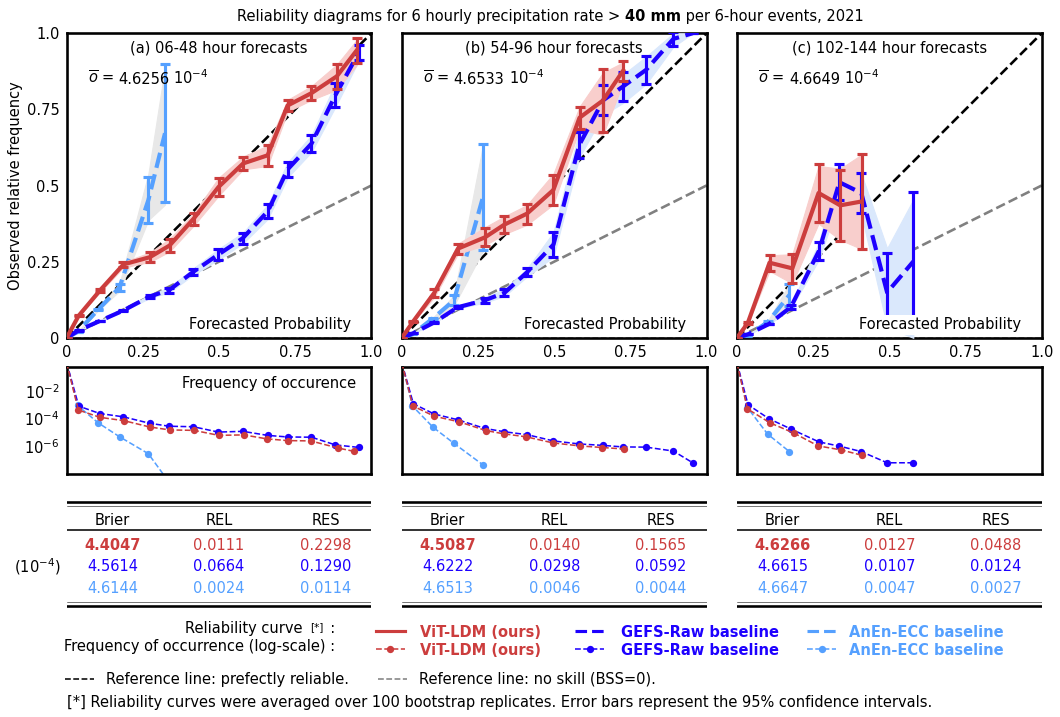

In [8]:
RESULTS_LDM = [name_LDM_40.format(0, 8), name_LDM_40.format(8, 16), name_LDM_40.format(16, 24)]
RESULTS_RAW = [name_RAW_40.format(0, 8), name_RAW_40.format(8, 16), name_RAW_40.format(16, 24)]
RESULTS_AnEn = [name_AnEn_40.format(0, 8), name_AnEn_40.format(8, 16), name_AnEn_40.format(16, 24)]

val_scale = 1e4
val_scale_text = r'$10^{-4}$'

linestyles = ['-', '--', '--']
zorders_fill = [5, 4, 3]
zorders_line = [6, 5, 4]
zorder_word = 7

# ref line coords
fake_x = np.linspace(0, 1, 100)

# sub-title names
titles = ['(a) 06-48 hour forecasts', '(b) 54-96 hour forecasts', '(c) 102-144 hour forecasts']

# ylocs for contents blow the main part of the figure
## legend, legend for the ref lines, [*] words, [**] wordds 
locy_all_legends = [-0.08, -0.135, -0.165, -0.195] 

# empty label name as placeholders
label_ = ['                            ',
          '                                   ',
          '                         ']

# collection of handdles for drawing legends
handle_title = []
handle_lines = []
handle_errbar = []
handle_refline = []

fig = plt.figure(figsize=(13, 8), dpi=dpi_)

# ----------------------------------------------------------------- #
# axis arrangments
#gs = gridspec.GridSpec(3, 5, height_ratios=[1, 0.001, 0.22], width_ratios=[1, 0.1, 1, 0.1, 1,])
gs = gridspec.GridSpec(5, 5, height_ratios=[1, 0.01, 0.3, 0.075, 0.3], width_ratios=[1, 0.1, 1, 0.1, 1])

AX_main = []; AX_text = []; AX_hist = []

for i in [0, 2, 4]:
    AX_main.append(plt.subplot(gs[0, i]))
    AX_hist.append(plt.subplot(gs[2, i]))
    AX_text.append(plt.subplot(gs[4, i]))

plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

# ----------------------------------------------------------------- #
# Overall title
ax_title = fig.add_axes([0.0, 0.97, 1.0, 0.03])
title_len = 0.65
handle_title += gu.string_partial_format(fig, ax_title, 0.5*(1-title_len), 0.5, 'left', 'center', 
                                         ['Reliability diagrams for 6 hourly precipitation rate > ', '40 mm', 
                                         ' per 6-hour events, 2021'], ['k',]*3, [14,]*3, ['normal', 'bold', 'normal'])
for handle in handle_title:
    handle.set_bbox(dict(facecolor='w', pad=0, edgecolor='none'))

# ----------------------------------------------------------------- #
# axis settings for the reliability diagram (main)
for i, ax in enumerate(AX_main):
    # sub-title
    ax.text(0.5, 0.975, titles[i], ha='center', va='top', fontsize=14, transform=ax.transAxes)
    # xlabel
    handle_xlabel= ax.text(0.4, 0.02, 'Forecasted Probability', ha='left', va='bottom', fontsize=14, transform=ax.transAxes, zorder=6)
    handle_xlabel.set_bbox(dict(facecolor='w', edgecolor='w', pad=2))
    # axis settings
    ax = gu.ax_decorate_box(ax)
    ax.tick_params(axis="both", which="both", labelbottom=True)
    ax.set_xlim([0, 1])
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_ylim([0, 1])
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_aspect('equal')
    
# left side y-axis ticks and label
AX_main[0].set_ylabel('Observed relative frequency', fontsize=14)
AX_main[0].tick_params(axis="both", which="both", labelleft=True)

# ----------------------------------------------------------------- #
# axis settings for the frequency of use subplots
YLIM = [1e-8, 5e-1]; YLAB = [1e-6, 1e-4, 1e-2]
# axis settings
for i, ax in enumerate(AX_hist):
    ax = gu.ax_decorate_box(ax)
    ax.set_xlim([0, 1])
    ax.set_xticks([0, 0.5, 1.0])
    ax.set_xticklabels([0, 0.5, 1.0])
    ax.set_yscale('log')
    ax.set_ylim(YLIM)
    ax.set_yticks(YLAB)

AX_hist[0].text(0.95, 0.92, 'Frequency of occurence', ha='right', va='top', 
                fontsize=14, transform=AX_hist[0].transAxes)
AX_hist[0].tick_params(axis="both", which="both", labelleft=True)

# ----------------------------------------------------------------- #
# axis settings for bs component tables
for i, ax in enumerate(AX_text):
    ax.axhline(0.990, xmin=0, xmax=1, linewidth=2.5, color='k')
    ax.axhline(0.950, xmin=0, xmax=1, linewidth=0.5, color='k')
    ax.axhline(0.725, xmin=0, xmax=1, linewidth=1.5, color='k')
    ax.axhline(0.050, xmin=0, xmax=1, linewidth=0.5, color='k')
    ax.axhline(0.010, xmin=0, xmax=1, linewidth=2.5, color='k')
# ----------------------------------------------------------------- #
# Tabel location settings
locx_head = [0.15, 0.5, 0.85] # locations of each column
locy_text = [0.65, 0.45, 0.25] # locations of each row
table_heads = ['Brier', 'REL', 'RES'] # tabel headings
fw_collection = ['bold', 'normal', 'normal'] # bold vs. normal font
# ----------------------------------------------------------------- #

for i in range(3):
    # get the axis for 0-48 vs. 48-96 vs. 96-144
    ax = AX_main[i]; ax_hist = AX_hist[i]; ax_text = AX_text[i]

    # add tabel headings
    for t in range(3):
        ax_text.text(locx_head[t], 0.74, table_heads[t], ha='center', va='bottom', 
                     fontsize=14, transform=ax_text.transAxes)
        
    # ------------------------------------------------------------------------------------------------------- #
    # tuple order: prob_true, prob_pred, bins, use, o_bar, prob_pred_mean, prob_true_mean, rel, res, o_bar, bs
    name_LDM = RESULTS_LDM[i]
    bundle_LDM = np.load(name_LDM, allow_pickle=True)[()]['save_bundle']
    name_AnEn = RESULTS_AnEn[i]
    bundle_AnEn = np.load(name_AnEn, allow_pickle=True)[()]['save_bundle']
    name_RAW = RESULTS_RAW[i]
    bundle_RAW = np.load(name_RAW, allow_pickle=True)[()]['save_bundle']
    bundle_collection = [bundle_LDM, bundle_RAW, bundle_AnEn,]
    
    for t, bundle in enumerate(bundle_collection):
        # ---------------------------------------------------------------- #
        # reliability diagram reference lines
        if t == 0:
            o_bar = bundle[-2]
            fake_y = 0.5*fake_x + 0.5*o_bar
            # climatology reference
            ax.text(0.07, 0.825, r'$\overline{o}$ = ', ha='left', va='bottom', 
                    fontsize=14, zorder=zorder_word, transform=ax.transAxes)
            
            ax.text(0.17, 0.825, '{:.4f}'.format(val_scale*o_bar), ha='left', 
                    va='bottom', fontsize=14, zorder=zorder_word, transform=ax.transAxes)
            
            ax.text(0.35, 0.825, val_scale_text, ha='left', va='bottom', 
                    fontsize=14, zorder=zorder_word, transform=ax.transAxes)
            
            ax.axvline(x=o_bar, ymin=0, ymax=1, linewidth=1.5, linestyle='--', color='0.5')
            ax.axhline(y=o_bar, xmin=0, xmax=1, linewidth=1.5, linestyle='--', color='0.5')
            # x=y line
            ax.plot(fake_x, fake_x, linewidth=2.5, linestyle='--', color='k')
            # bss=0 line
            ax.plot(fake_x, fake_y, linewidth=2.5, linestyle='--', color='0.5')

        # ---------------------------------------------------------------- #
        # reliability curves with boostrapping errorbars

        # 0.01 - 0.99 errorbar range
        temp_99 = np.quantile(bundle[0], 0.95, axis=1)
        temp_01 = np.quantile(bundle[0], 0.05, axis=1)
        error = 0.5*(temp_99 - temp_01)
        # draw reliability curves

        ax.fill_between(bundle[5], temp_01, temp_99, interpolate=True, 
                        color=colors_sub[t], zorder=zorders_fill[t])
        (_, caps, _) = ax.errorbar(bundle[5], bundle[6], yerr=error, linestyle=linestyles[t], capsize=5, 
                                   color=colors_main[t], linewidth=4.0, elinewidth=3.0, zorder=zorders_line[t])
        for cap in caps:
            cap.set_markeredgewidth(3)
        # ---------------------------------------------------------------- #
        # frequency of occurrence curves

        # get frequency of occurrence from occurrence counts
        use = bundle[3]; use[np.isnan(use)] = 0 # np.nan = no occurrence = 0

        # draw frequency of occurrence curves
        handle_lines += ax_hist.plot(bundle[2], use/np.sum(use), 
                                     color=colors_main[t], linestyle='--', linewidth=1.5, 
                                     marker='o', ms=7, mew=0, mfc=colors_main[t], label=label_[t], zorder=3-t)
        # ---------------------------------------------------------------- #
        # tabels for bs components
        ax_text.text(locx_head[0], locy_text[t], '{:.4f}'.format(val_scale*bundle[-1]), ha='center', va='top', 
                     color=colors_main[t], fontsize=14, fontweight=fw_collection[t], transform=ax_text.transAxes)
        ax_text.text(locx_head[1], locy_text[t], '{:.4f}'.format(val_scale*bundle[-4]), ha='center', 
                     va='top', color=colors_main[t], fontsize=14, transform=ax_text.transAxes)
        ax_text.text(locx_head[2], locy_text[t], '{:.4f}'.format(val_scale*bundle[-3]), ha='center', 
                     va='top', color=colors_main[t], fontsize=14, transform=ax_text.transAxes)
# draw the unit of bs components
AX_text[0].text(-0.02, 0.475, '('+val_scale_text+')', ha='right', va='top', fontsize=14, transform=AX_text[0].transAxes)

# ----------------------------------------------------------------- #
# legends of reliability curves and frequency of occurrence curves

# pseudo legned handles for reliability curves
for t in range(3):
    handle_errbar.append(mlines.Line2D([], [], label=label_[t], linestyle=linestyles[t], 
                                       color=colors_main[t], linewidth=3.0,))

# get the axis for the entire legend
ax_box = fig.add_axes([0, locy_all_legends[0], 1, 0.06])
ax_box.set_axis_off()

# subset the axis into heading (15% length) and legend content (85%)
ax_lw1 = inset_axes(ax_box, height='50%', width='28%', borderpad=0, loc=2)
ax_lw2 = inset_axes(ax_box, height='50%', width='28%', borderpad=0, loc=3)
ax_lg1 = inset_axes(ax_box, height='50%', width='72%', borderpad=0, loc=1)
ax_lg2 = inset_axes(ax_box, height='50%', width='72%', borderpad=0, loc=4)

# add legend headings
ax_lw1.text(1, 0.5, 'Reliability curve      : ', 
            ha='right', va='center', fontsize=14, transform=ax_lw1.transAxes);

ax_lw2.text(1, 0.5, 'Frequency of occurrence (log-scale) : ', 
            ha='right', va='center', fontsize=14, transform=ax_lw2.transAxes);

ax_lw1.text(0.94, 0.58, '[*]', ha='right', va='center', fontsize=10, transform=ax_lw1.transAxes);

# add legend content for reliability curves
LG1 = ax_lg1.legend(handles=handle_errbar, bbox_to_anchor=(0.9075, 1.5), 
                   ncol=3, prop={'size':14}, fancybox=False); gu.legend_format(LG1)

# add legend content for frequency of occurrence curves
LG2 = ax_lg2.legend(handles=handle_lines[0:3], bbox_to_anchor=(0.9075, 1.5), 
                    ncol=3, prop={'size':14}, fancybox=False); gu.legend_format(LG2)

# add legend texts
locx_legend = [0.115, 0.4, 0.725]
locy_legend = 0.7
names_legend = ['ViT-LDM (ours)', 'GEFS-Raw baseline', 'AnEn-ECC baseline']

for t in range(3):
    ax_lg1.text(locx_legend[t], locy_legend, names_legend[t], ha='left', va='top', 
                fontsize=14, fontweight='bold', color=colors_main[t], transform=ax_lg1.transAxes)
    
    ax_lg2.text(locx_legend[t], locy_legend, names_legend[t], ha='left', va='top', 
                fontsize=14, fontweight='bold', color=colors_main[t], transform=ax_lg2.transAxes)

# ----------------------------------------------------------------- #
# legends of reference lines

# pseudo legned handles for reference lines
handle_refline.append(mlines.Line2D([], [], label='Reference line: prefectly reliable.', 
                                    linestyle='--', color='k', linewidth=1.5))

handle_refline.append(mlines.Line2D([], [], label='Reference line: no skill (BSS=0).', 
                                    linestyle='--', color='0.5', linewidth=1.5))

ax_lg3 = fig.add_axes([0, locy_all_legends[1], 0.675, 0.05])
LG3 = ax_lg3.legend(handles=handle_refline, bbox_to_anchor=(0.915, 1), ncol=2, 
                    prop={'size':14}, fancybox=False); gu.legend_format(LG3)

# ----------------------------------------------------------------- #

ax_words2 = fig.add_axes([0, locy_all_legends[2], 1.0, 0.02])
ax_words2.text(0, 1, 
     '[*] Reliability curves were averaged over 100 bootstrap replicates. Error bars represent the 95% confidence intervals.', 
      ha='left', va='top', fontsize=14, transform=ax_words2.transAxes);

# ----------------------------------------------------------------- #
# turn-off all axis
ax_lw1.set_axis_off()
ax_lg1.set_axis_off()
ax_lw2.set_axis_off()
ax_lg2.set_axis_off()
ax_lg3.set_axis_off()
ax_title.set_axis_off()
ax_words2.set_axis_off()
for i, ax in enumerate(AX_text):
    ax.set_axis_off()

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'fig9_reliability_diagram_40mm.png', format='png', **fig_keys)

## Full domain 99th percentile threshold

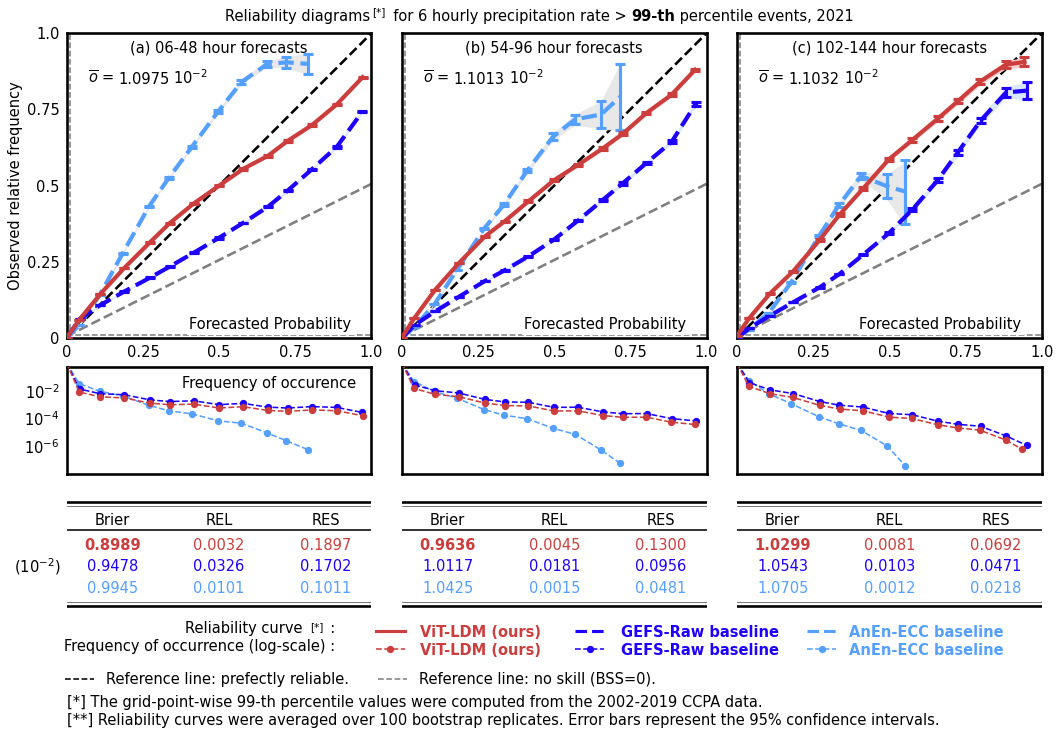

In [9]:
RESULTS_LDM = [name_LDM_full_p99.format(0, 8), name_LDM_full_p99.format(8, 16), name_LDM_full_p99.format(16, 24)]
RESULTS_AnEn = [name_AnEn_full_p99.format(0, 8), name_AnEn_full_p99.format(8, 16), name_AnEn_full_p99.format(16, 24)]
RESULTS_RAW = [name_RAW_full_p99.format(0, 8), name_RAW_full_p99.format(8, 16), name_RAW_full_p99.format(16, 24)]

val_scale = 1e2
val_scale_text = r'$10^{-2}$'

linestyles = ['-', '--', '--']
zorders_fill = [5, 4, 3]
zorders_line = [6, 5, 4]
zorder_word = 7

# ref line coords
fake_x = np.linspace(0, 1, 100)

# sub-title names
titles = ['(a) 06-48 hour forecasts', '(b) 54-96 hour forecasts', '(c) 102-144 hour forecasts']

# ylocs for contents blow the main part of the figure
## legend, legend for the ref lines, [*] words, [**] wordds 
locy_all_legends = [-0.08, -0.135, -0.165, -0.195] 

# empty label name as placeholders
label_ = ['                            ',
          '                                   ',
          '                         ']

# collection of handdles for drawing legends
handle_title = []
handle_lines = []
handle_errbar = []
handle_refline = []

fig = plt.figure(figsize=(13, 8), dpi=dpi_)

# ----------------------------------------------------------------- #
# axis arrangments
#gs = gridspec.GridSpec(3, 5, height_ratios=[1, 0.001, 0.22], width_ratios=[1, 0.1, 1, 0.1, 1,])
gs = gridspec.GridSpec(5, 5, height_ratios=[1, 0.01, 0.3, 0.075, 0.3], width_ratios=[1, 0.1, 1, 0.1, 1])

AX_main = []; AX_text = []; AX_hist = []

for i in [0, 2, 4]:
    AX_main.append(plt.subplot(gs[0, i]))
    AX_hist.append(plt.subplot(gs[2, i]))
    AX_text.append(plt.subplot(gs[4, i]))

plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

# ----------------------------------------------------------------- #
# Overall title
ax_title = fig.add_axes([0.0, 0.97, 1.0, 0.03])
title_len = 0.675
handle_title += gu.string_partial_format(fig, ax_title, 0.5*(1-title_len), 0.5, 'left', 'center', 
                                         ['Reliability diagrams     for 6 hourly precipitation rate > ', '99-th', 
                                         ' percentile events, 2021'], ['k',]*3, [14,]*3, ['normal', 'bold', 'normal'])
ax_title.text(0.327, 1.0, '[*]', ha='right', va='top', fontsize=10, transform=ax_title.transAxes);
for handle in handle_title:
    handle.set_bbox(dict(facecolor='w', pad=0, edgecolor='none'))

# ----------------------------------------------------------------- #
# axis settings for the reliability diagram (main)
for i, ax in enumerate(AX_main):
    # sub-title
    ax.text(0.5, 0.975, titles[i], ha='center', va='top', fontsize=14, transform=ax.transAxes)
    # xlabel
    handle_xlabel= ax.text(0.4, 0.02, 'Forecasted Probability', ha='left', va='bottom', fontsize=14, transform=ax.transAxes, zorder=6)
    handle_xlabel.set_bbox(dict(facecolor='w', edgecolor='w', pad=2))
    # axis settings
    ax = gu.ax_decorate_box(ax)
    ax.tick_params(axis="both", which="both", labelbottom=True)
    ax.set_xlim([0, 1])
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_ylim([0, 1])
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels([0, 0.25, 0.5, 0.75, 1.0])
    ax.set_aspect('equal')
    
# left side y-axis ticks and label
AX_main[0].set_ylabel('Observed relative frequency', fontsize=14)
AX_main[0].tick_params(axis="both", which="both", labelleft=True)

# ----------------------------------------------------------------- #
# axis settings for the frequency of use subplots
YLIM = [1e-8, 5e-1]; YLAB = [1e-6, 1e-4, 1e-2]
# axis settings
for i, ax in enumerate(AX_hist):
    ax = gu.ax_decorate_box(ax)
    ax.set_xlim([0, 1])
    ax.set_xticks([0, 0.5, 1.0])
    ax.set_xticklabels([0, 0.5, 1.0])
    ax.set_yscale('log')
    ax.set_ylim(YLIM)
    ax.set_yticks(YLAB)

AX_hist[0].text(0.95, 0.92, 'Frequency of occurence', ha='right', va='top', 
                fontsize=14, transform=AX_hist[0].transAxes)
AX_hist[0].tick_params(axis="both", which="both", labelleft=True)

# ----------------------------------------------------------------- #
# axis settings for bs component tables
for i, ax in enumerate(AX_text):
    ax.axhline(0.990, xmin=0, xmax=1, linewidth=2.5, color='k')
    ax.axhline(0.950, xmin=0, xmax=1, linewidth=0.5, color='k')
    ax.axhline(0.725, xmin=0, xmax=1, linewidth=1.5, color='k')
    ax.axhline(0.050, xmin=0, xmax=1, linewidth=0.5, color='k')
    ax.axhline(0.010, xmin=0, xmax=1, linewidth=2.5, color='k')
# ----------------------------------------------------------------- #
# Tabel location settings
locx_head = [0.15, 0.5, 0.85] # locations of each column
locy_text = [0.65, 0.45, 0.25] # locations of each row
table_heads = ['Brier', 'REL', 'RES'] # tabel headings
fw_collection = ['bold', 'normal', 'normal'] # bold vs. normal font
# ----------------------------------------------------------------- #

for i in range(3):
    # get the axis for 0-48 vs. 48-96 vs. 96-144
    ax = AX_main[i]; ax_hist = AX_hist[i]; ax_text = AX_text[i]

    # add tabel headings
    for t in range(3):
        ax_text.text(locx_head[t], 0.74, table_heads[t], ha='center', va='bottom', 
                     fontsize=14, transform=ax_text.transAxes)
        
    # ------------------------------------------------------------------------------------------------------- #
    # tuple order: prob_true, prob_pred, bins, use, o_bar, prob_pred_mean, prob_true_mean, rel, res, o_bar, bs
    name_LDM = RESULTS_LDM[i]
    bundle_LDM = np.load(name_LDM, allow_pickle=True)[()]['save_bundle']
    name_AnEn = RESULTS_AnEn[i]
    bundle_AnEn = np.load(name_AnEn, allow_pickle=True)[()]['save_bundle']
    name_RAW = RESULTS_RAW[i]
    bundle_RAW = np.load(name_RAW, allow_pickle=True)[()]['save_bundle']
    bundle_collection = [bundle_LDM, bundle_RAW, bundle_AnEn,]
    
    for t, bundle in enumerate(bundle_collection):
        # ---------------------------------------------------------------- #
        # reliability diagram reference lines
        if t == 0:
            o_bar = bundle[-2]
            fake_y = 0.5*fake_x + 0.5*o_bar
            # climatology reference
            ax.text(0.07, 0.825, r'$\overline{o}$ = ', ha='left', va='bottom', 
                    fontsize=14, zorder=zorder_word, transform=ax.transAxes)
            
            ax.text(0.17, 0.825, '{:.4f}'.format(val_scale*o_bar), ha='left', 
                    va='bottom', fontsize=14, zorder=zorder_word, transform=ax.transAxes)
            
            ax.text(0.35, 0.825, val_scale_text, ha='left', va='bottom', 
                    fontsize=14, zorder=zorder_word, transform=ax.transAxes)
            
            ax.axvline(x=o_bar, ymin=0, ymax=1, linewidth=1.5, linestyle='--', color='0.5')
            ax.axhline(y=o_bar, xmin=0, xmax=1, linewidth=1.5, linestyle='--', color='0.5')
            # x=y line
            ax.plot(fake_x, fake_x, linewidth=2.5, linestyle='--', color='k')
            # bss=0 line
            ax.plot(fake_x, fake_y, linewidth=2.5, linestyle='--', color='0.5')

        # ---------------------------------------------------------------- #
        # reliability curves with boostrapping errorbars

        # 0.01 - 0.99 errorbar range
        temp_99 = np.quantile(bundle[0], 0.95, axis=1)
        temp_01 = np.quantile(bundle[0], 0.05, axis=1)
        error = 0.5*(temp_99 - temp_01)
        # draw reliability curves

        ax.fill_between(bundle[5], temp_01, temp_99, interpolate=True, 
                        color=colors_sub[t], zorder=zorders_fill[t])
        (_, caps, _) = ax.errorbar(bundle[5], bundle[6], yerr=error, linestyle=linestyles[t], capsize=5, 
                                   color=colors_main[t], linewidth=4.0, elinewidth=3.0, zorder=zorders_line[t])
        for cap in caps:
            cap.set_markeredgewidth(3)
        # ---------------------------------------------------------------- #
        # frequency of occurrence curves

        # get frequency of occurrence from occurrence counts
        use = bundle[3]; use[np.isnan(use)] = 0 # np.nan = no occurrence = 0

        # draw frequency of occurrence curves
        handle_lines += ax_hist.plot(bundle[2], use/np.sum(use), 
                                     color=colors_main[t], linestyle='--', linewidth=1.5, 
                                     marker='o', ms=7, mew=0, mfc=colors_main[t], label=label_[t], zorder=3-t)
        # ---------------------------------------------------------------- #
        # tabels for bs components
        ax_text.text(locx_head[0], locy_text[t], '{:.4f}'.format(val_scale*bundle[-1]), ha='center', va='top', 
                     color=colors_main[t], fontsize=14, fontweight=fw_collection[t], transform=ax_text.transAxes)
        ax_text.text(locx_head[1], locy_text[t], '{:.4f}'.format(val_scale*bundle[-4]), ha='center', 
                     va='top', color=colors_main[t], fontsize=14, transform=ax_text.transAxes)
        ax_text.text(locx_head[2], locy_text[t], '{:.4f}'.format(val_scale*bundle[-3]), ha='center', 
                     va='top', color=colors_main[t], fontsize=14, transform=ax_text.transAxes)
# draw the unit of bs components
AX_text[0].text(-0.02, 0.475, '('+val_scale_text+')', ha='right', va='top', fontsize=14, transform=AX_text[0].transAxes)

# ----------------------------------------------------------------- #
# legends of reliability curves and frequency of occurrence curves

# pseudo legned handles for reliability curves
for t in range(3):
    handle_errbar.append(mlines.Line2D([], [], label=label_[t], linestyle=linestyles[t], 
                                       color=colors_main[t], linewidth=3.0,))

# get the axis for the entire legend
ax_box = fig.add_axes([0, locy_all_legends[0], 1, 0.06])
ax_box.set_axis_off()

# subset the axis into heading (15% length) and legend content (85%)
ax_lw1 = inset_axes(ax_box, height='50%', width='28%', borderpad=0, loc=2)
ax_lw2 = inset_axes(ax_box, height='50%', width='28%', borderpad=0, loc=3)
ax_lg1 = inset_axes(ax_box, height='50%', width='72%', borderpad=0, loc=1)
ax_lg2 = inset_axes(ax_box, height='50%', width='72%', borderpad=0, loc=4)

# add legend headings
ax_lw1.text(1, 0.5, 'Reliability curve      : ', 
            ha='right', va='center', fontsize=14, transform=ax_lw1.transAxes);

ax_lw2.text(1, 0.5, 'Frequency of occurrence (log-scale) : ', 
            ha='right', va='center', fontsize=14, transform=ax_lw2.transAxes);

ax_lw1.text(0.94, 0.58, '[*]', ha='right', va='center', fontsize=10, transform=ax_lw1.transAxes);

# add legend content for reliability curves
LG1 = ax_lg1.legend(handles=handle_errbar, bbox_to_anchor=(0.9075, 1.5), 
                   ncol=3, prop={'size':14}, fancybox=False); gu.legend_format(LG1)

# add legend content for frequency of occurrence curves
LG2 = ax_lg2.legend(handles=handle_lines[0:3], bbox_to_anchor=(0.9075, 1.5), 
                    ncol=3, prop={'size':14}, fancybox=False); gu.legend_format(LG2)

# add legend texts
locx_legend = [0.115, 0.4, 0.725]
locy_legend = 0.7
names_legend = ['ViT-LDM (ours)', 'GEFS-Raw baseline', 'AnEn-ECC baseline']

for t in range(3):
    ax_lg1.text(locx_legend[t], locy_legend, names_legend[t], ha='left', va='top', 
                fontsize=14, fontweight='bold', color=colors_main[t], transform=ax_lg1.transAxes)
    
    ax_lg2.text(locx_legend[t], locy_legend, names_legend[t], ha='left', va='top', 
                fontsize=14, fontweight='bold', color=colors_main[t], transform=ax_lg2.transAxes)

# ----------------------------------------------------------------- #
# legends of reference lines

# pseudo legned handles for reference lines
handle_refline.append(mlines.Line2D([], [], label='Reference line: prefectly reliable.', 
                                    linestyle='--', color='k', linewidth=1.5))

handle_refline.append(mlines.Line2D([], [], label='Reference line: no skill (BSS=0).', 
                                    linestyle='--', color='0.5', linewidth=1.5))

ax_lg3 = fig.add_axes([0, locy_all_legends[1], 0.675, 0.05])
LG3 = ax_lg3.legend(handles=handle_refline, bbox_to_anchor=(0.915, 1), ncol=2, 
                    prop={'size':14}, fancybox=False); gu.legend_format(LG3)

# ----------------------------------------------------------------- #
# [*] words
ax_words1 = fig.add_axes([0, locy_all_legends[2], 1.0, 0.02])
ax_words1.text(0, 1, '[*] The grid-point-wise 99-th percentile values were computed from the 2002-2019 CCPA data.', 
              ha='left', va='top', fontsize=14, transform=ax_words1.transAxes);

ax_words2 = fig.add_axes([0, locy_all_legends[3], 1.0, 0.02])
ax_words2.text(0, 1, 
    '[**] Reliability curves were averaged over 100 bootstrap replicates. Error bars represent the 95% confidence intervals.', 
    ha='left', va='top', fontsize=14, transform=ax_words2.transAxes);

# ----------------------------------------------------------------- #
# turn-off all axis
ax_lw1.set_axis_off()
ax_lg1.set_axis_off()
ax_lw2.set_axis_off()
ax_lg2.set_axis_off()
ax_lg3.set_axis_off()
ax_title.set_axis_off()
ax_words1.set_axis_off()
ax_words2.set_axis_off()
for i, ax in enumerate(AX_text):
    ax.set_axis_off()

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'fig10_reliability_diagram_99.png', format='png', **fig_keys)

## 6-day accumulated 99th percentile threshold

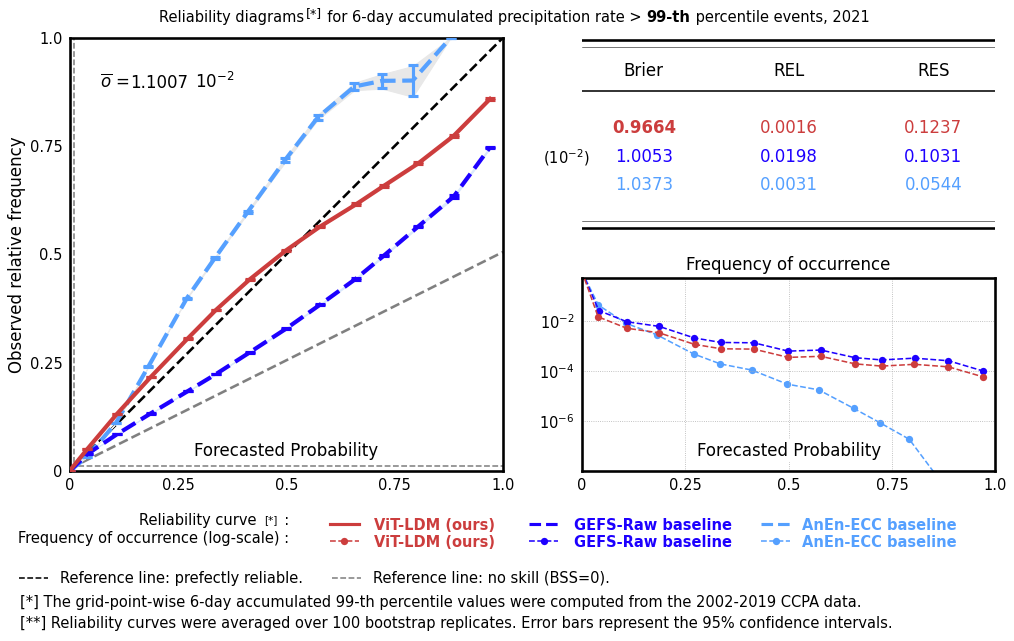

In [10]:
RESULTS_LDM = name_LDM_accum
RESULTS_AnEn = name_AnEn_accum
RESULTS_RAW = name_RAW_accum

val_scale = 1e2
val_scale_text = r'$10^{-2}$'

linestyles = ['-', '--', '--']
zorders_fill = [5, 4, 3]
zorders_line = [6, 5, 4]
zorder_word = 7

# ref line coords
fake_x = np.linspace(0, 1, 100)

# ylocs for contents blow the main part of the figure
## legend, legend for the ref lines, [*] words, [**] wordds 
locy_all_legends = [-0.175, -0.275, -0.325, -0.375] 

# empty label name as placeholders
label_ = ['                            ',
          '                                   ',
          '                         ']

# collection of handdles for drawing legends
handle_title = []
handle_lines = []
handle_errbar = []
handle_refline = []

h_ratio = np.array([0.5, 0.125, 0.5])

fig = plt.figure(figsize=(13, 13*h_ratio[0]/h_ratio.sum()), dpi=dpi_)

# ----------------------------------------------------------------- #
# axis arrangments
gs = gridspec.GridSpec(3, 3, height_ratios=h_ratio, width_ratios=[0.45, 0.025, 0.35])

AX_main = plt.subplot(gs[:, 0])
AX_text = plt.subplot(gs[0, 2])
AX_hist = plt.subplot(gs[2, 2])

plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0)

# ----------------------------------------------------------------- #
# Overall title
ax_title = fig.add_axes([0.0, 1.025, 1.0, 0.045])
title_len = 0.715
handle_title += gu.string_partial_format(fig, ax_title, 0.5*(1-title_len), 0.5, 'left', 'center', 
                                         ['Reliability diagrams     for 6-day accumulated precipitation rate > ', '99-th', 
                                         ' percentile events, 2021'], ['k',]*3, [14,]*3, ['normal', 'bold', 'normal'])
ax_title.text(0.309, 1.0, '[*]', ha='right', va='top', fontsize=12, transform=ax_title.transAxes);
for handle in handle_title:
    handle.set_bbox(dict(facecolor='w', pad=0, edgecolor='none'))

# ----------------------------------------------------------------- #
# axis settings for the reliability diagram (main)
ax = AX_main
handle_xlabel= ax.text(0.5, 0.025, 'Forecasted Probability', ha='center', 
                       va='bottom', fontsize=16, transform=ax.transAxes, zorder=6)
handle_xlabel.set_bbox(dict(facecolor='w', edgecolor='w', pad=2))
# axis settings
ax = gu.ax_decorate_box(ax)
ax.tick_params(axis="both", which="both", labelleft=True, labelbottom=True)
ax.set_xlim([0, 1])
ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1.0])
ax.set_ylim([0, 1])
ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels([0, 0.25, 0.5, 0.75, 1.0])
ax.set_aspect('equal')
ax.set_ylabel('Observed relative frequency', fontsize=16)
# ax.yaxis.set_label_coords(0.075, 0.5)
# ----------------------------------------------------------------- #
# axis settings for the frequency of use subplots
YLIM = [1e-8, 5e-1]; YLAB = [1e-6, 1e-4, 1e-2]
# axis settings
ax = AX_hist
handle_xlabel= ax.text(0.5, 0.06, 'Forecasted Probability', ha='center', 
                       va='bottom', fontsize=16, transform=ax.transAxes, zorder=6)
handle_xlabel.set_bbox(dict(facecolor='w', edgecolor='w', pad=2))
ax = gu.ax_decorate_box(ax)
ax.grid(linestyle=':')

# sub-title
handle_freq = ax.text(0.5, 1.025, 'Frequency of occurrence', ha='center', va='bottom', fontsize=16, transform=ax.transAxes)
handle_freq.set_bbox(dict(facecolor='w', edgecolor='w', pad=2))

ax.tick_params(axis="both", which="both", labelleft=True, labelbottom=True)
ax.set_xlim([0, 1])
ax.set_xticks([0, 0.25, 0.5, 0.75, 1.0])
ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1.0])
ax.set_yscale('log')
ax.set_ylim(YLIM)
ax.set_yticks(YLAB)
ax.tick_params(axis="both", which="both", labelleft=True)

# ----------------------------------------------------------------- #
# axis settings for bs component tables
ax = AX_text
ax.axhline(0.990, xmin=0, xmax=1, linewidth=2.5, color='k')
ax.axhline(0.950, xmin=0, xmax=1, linewidth=0.5, color='k')
ax.axhline(0.725, xmin=0, xmax=1, linewidth=1.5, color='k')
ax.axhline(0.050, xmin=0, xmax=1, linewidth=0.5, color='k')
ax.axhline(0.010, xmin=0, xmax=1, linewidth=2.5, color='k')
# ----------------------------------------------------------------- #
# Tabel location settings
locx_head = [0.15, 0.5, 0.85] # locations of each column
locy_text = [0.58, 0.43, 0.28] # locations of each row
table_heads = ['Brier', 'REL', 'RES'] # tabel headings
fw_collection = ['bold', 'normal', 'normal'] # bold vs. normal font

# ----------------------------------------------------------------- #
ax = AX_main
ax_text = AX_text
ax_hist = AX_hist
# ---------------------- $

# add tabel headings
for t in range(3):
    ax_text.text(locx_head[t], 0.78, table_heads[t], ha='center', va='bottom', 
                 fontsize=16, transform=ax_text.transAxes)
    
# ------------------------------------------------------------------------------------------------------- #
# tuple order: prob_true, prob_pred, bins, use, o_bar, prob_pred_mean, prob_true_mean, rel, res, o_bar, bs
name_LDM = RESULTS_LDM
bundle_LDM = np.load(name_LDM, allow_pickle=True)[()]['save_bundle']
name_AnEn = RESULTS_AnEn
bundle_AnEn = np.load(name_AnEn, allow_pickle=True)[()]['save_bundle']
name_RAW = RESULTS_RAW
bundle_RAW = np.load(name_RAW, allow_pickle=True)[()]['save_bundle']
bundle_collection = [bundle_LDM, bundle_RAW, bundle_AnEn,]

for t, bundle in enumerate(bundle_collection):
    # ---------------------------------------------------------------- #
    # reliability diagram reference lines
    if t == 0:
        o_bar = bundle[-2]
        fake_y = 0.5*fake_x + 0.5*o_bar
        # climatology reference
        ax.text(0.07, 0.875, r'$\overline{o}$ = ', ha='left', va='bottom', 
                fontsize=16, zorder=zorder_word, transform=ax.transAxes)
        
        ax.text(0.14, 0.875, '{:.4f}'.format(val_scale*o_bar), ha='left', 
                va='bottom', fontsize=16, zorder=zorder_word, transform=ax.transAxes)
        
        ax.text(0.29, 0.875, val_scale_text, ha='left', va='bottom', 
                fontsize=16, zorder=zorder_word, transform=ax.transAxes)
        
        ax.axvline(x=o_bar, ymin=0, ymax=1, linewidth=1.5, linestyle='--', color='0.5')
        ax.axhline(y=o_bar, xmin=0, xmax=1, linewidth=1.5, linestyle='--', color='0.5')
        # x=y line
        ax.plot(fake_x, fake_x, linewidth=2.5, linestyle='--', color='k')
        # bss=0 line
        ax.plot(fake_x, fake_y, linewidth=2.5, linestyle='--', color='0.5')

    # ---------------------------------------------------------------- #
    # reliability curves with boostrapping errorbars

    # 0.01 - 0.99 errorbar range
    temp_99 = np.quantile(bundle[0], 0.95, axis=1)
    temp_01 = np.quantile(bundle[0], 0.05, axis=1)
    error = 0.5*(temp_99 - temp_01)
    # draw reliability curves

    ax.fill_between(bundle[5], temp_01, temp_99, interpolate=True, 
                    color=colors_sub[t], zorder=zorders_fill[t])
    (_, caps, _) = ax.errorbar(bundle[5], bundle[6], yerr=error, linestyle=linestyles[t], capsize=5, 
                               color=colors_main[t], linewidth=4.0, elinewidth=3.0, zorder=zorders_line[t])
    for cap in caps:
        cap.set_markeredgewidth(3)
    # ---------------------------------------------------------------- #
    # frequency of occurrence curves

    # get frequency of occurrence from occurrence counts
    use = bundle[3]; use[np.isnan(use)] = 0 # np.nan = no occurrence = 0

    # draw frequency of occurrence curves
    handle_lines += ax_hist.plot(bundle[2], use/np.sum(use), 
                                 color=colors_main[t], linestyle='--', linewidth=1.5, 
                                 marker='o', ms=7, mew=0, mfc=colors_main[t], label=label_[t], zorder=3-t)
    # ---------------------------------------------------------------- #
    # tabels for bs components
    ax_text.text(locx_head[0], locy_text[t], '{:.4f}'.format(val_scale*bundle[-1]), ha='center', va='top', 
                 color=colors_main[t], fontsize=16, fontweight=fw_collection[t], transform=ax_text.transAxes)
    ax_text.text(locx_head[1], locy_text[t], '{:.4f}'.format(val_scale*bundle[-4]), ha='center', 
                 va='top', color=colors_main[t], fontsize=16, transform=ax_text.transAxes)
    ax_text.text(locx_head[2], locy_text[t], '{:.4f}'.format(val_scale*bundle[-3]), ha='center', 
                 va='top', color=colors_main[t], fontsize=16, transform=ax_text.transAxes)

# draw the unit of bs components
AX_text.text(0.018, locy_text[1], '('+val_scale_text+')', ha='right', va='top', fontsize=14, transform=AX_text.transAxes)

# ----------------------------------------------------------------- #
# legends of reliability curves and frequency of occurrence curves

# pseudo legned handles for reliability curves
for t in range(3):
    handle_errbar.append(mlines.Line2D([], [], label=label_[t], linestyle=linestyles[t], 
                                       color=colors_main[t], linewidth=3.0,))

# get the axis for the entire legend
ax_box = fig.add_axes([0, locy_all_legends[0], 1, 0.08])
ax_box.set_axis_off()

# subset the axis into heading (15% length) and legend content (85%)
ax_lw1 = inset_axes(ax_box, height='50%', width='28%', borderpad=0, loc=2)
ax_lw2 = inset_axes(ax_box, height='50%', width='28%', borderpad=0, loc=3)
ax_lg1 = inset_axes(ax_box, height='50%', width='72%', borderpad=0, loc=1)
ax_lg2 = inset_axes(ax_box, height='50%', width='72%', borderpad=0, loc=4)

# add legend headings
ax_lw1.text(1, 0.5, 'Reliability curve      : ', 
            ha='right', va='center', fontsize=14, transform=ax_lw1.transAxes);

ax_lw2.text(1, 0.5, 'Frequency of occurrence (log-scale) : ', 
            ha='right', va='center', fontsize=14, transform=ax_lw2.transAxes);

ax_lw1.text(0.94, 0.58, '[*]', ha='right', va='center', fontsize=10, transform=ax_lw1.transAxes);

# add legend content for reliability curves
LG1 = ax_lg1.legend(handles=handle_errbar, bbox_to_anchor=(0.9075, 1.5), 
                   ncol=3, prop={'size':14}, fancybox=False); gu.legend_format(LG1)

# add legend content for frequency of occurrence curves
LG2 = ax_lg2.legend(handles=handle_lines[0:3], bbox_to_anchor=(0.9075, 1.5), 
                    ncol=3, prop={'size':14}, fancybox=False); gu.legend_format(LG2)

# add legend texts
locx_legend = [0.115, 0.4, 0.725]
locy_legend = 0.7
names_legend = ['ViT-LDM (ours)', 'GEFS-Raw baseline', 'AnEn-ECC baseline']

for t in range(3):
    ax_lg1.text(locx_legend[t], locy_legend, names_legend[t], ha='left', va='top', 
                fontsize=14, fontweight='bold', color=colors_main[t], transform=ax_lg1.transAxes)
    
    ax_lg2.text(locx_legend[t], locy_legend, names_legend[t], ha='left', va='top', 
                fontsize=14, fontweight='bold', color=colors_main[t], transform=ax_lg2.transAxes)

# ----------------------------------------------------------------- #
# legends of reference lines

# pseudo legned handles for reference lines
handle_refline.append(mlines.Line2D([], [], label='Reference line: prefectly reliable.', 
                                    linestyle='--', color='k', linewidth=1.5))

handle_refline.append(mlines.Line2D([], [], label='Reference line: no skill (BSS=0).', 
                                    linestyle='--', color='0.5', linewidth=1.5))

ax_lg3 = fig.add_axes([0, locy_all_legends[1], 0.675, 0.075])
LG3 = ax_lg3.legend(handles=handle_refline, bbox_to_anchor=(0.915, 1), ncol=2, 
                    prop={'size':14}, fancybox=False); gu.legend_format(LG3)

# ----------------------------------------------------------------- #
# [*] words
ax_words1 = fig.add_axes([0, locy_all_legends[2], 1.0, 0.04])
ax_words1.text(0, 1, '[*] The grid-point-wise 6-day accumulated 99-th percentile values were computed from the 2002-2019 CCPA data.', 
              ha='left', va='top', fontsize=14, transform=ax_words1.transAxes);

ax_words2 = fig.add_axes([0, locy_all_legends[3], 1.0, 0.04])
ax_words2.text(0, 1, 
    '[**] Reliability curves were averaged over 100 bootstrap replicates. Error bars represent the 95% confidence intervals.', 
    ha='left', va='top', fontsize=14, transform=ax_words2.transAxes);

# ----------------------------------------------------------------- #
# turn-off all axis
ax_lw1.set_axis_off()
ax_lg1.set_axis_off()
ax_lw2.set_axis_off()
ax_lg2.set_axis_off()
ax_lg3.set_axis_off()
ax_title.set_axis_off()
ax_words1.set_axis_off()
ax_words2.set_axis_off()
AX_text.set_axis_off()

if need_publish:
    # Save figure
    fig.savefig(fig_dir+'fig11_reliability_diagram_99_accum.png', format='png', **fig_keys)